In [50]:
import numpy as np
import pandas as pd
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import datasets, transforms, models
from torchvision.models import efficientnet_b0, efficientnet_v2_s
from torchvision.models import EfficientNet_B0_Weights, EfficientNet_V2_S_Weights
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
BATCH_SIZE = 512

mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

trainset = datasets.MNIST('../data/MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = datasets.MNIST('../data/MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
class PredictionHead(nn.Module):
    def __init__(self, feature_dims):
        super(PredictionHead, self).__init__()
        self.activate = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.fc = nn.Sequential()
        for i in range(len(feature_dims)-1):
            # self.fc.add_module(f'drop_{i}', self.dropout)
            self.fc.add_module(f'fc_{i}', nn.Linear(feature_dims[i], feature_dims[i+1]))
            if i != len(feature_dims)-2:
                self.fc.add_module(f'a_{i}', self.activate)

    def forward(self, x):
        x = self.fc(x)

        return x

In [40]:
def new_custom_effb0(hidden_features):
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    feature = [1280]
    feature.extend(hidden_features)
    model.classifier = PredictionHead(feature).cuda()

    new_conv_1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    new_conv_1.weight.data = model.features[0][0].weight.data.mean(dim=1, keepdim=True).clone().detach()

    model.features[0][0] = new_conv_1

    return model

In [41]:
model = new_custom_effb0([512, 256, 64, 10])
summary(model, input_size=(BATCH_SIZE, 1, 28, 28), device=device.type)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [512, 10]                 --
├─Sequential: 1-1                                       [512, 1280, 1, 1]         --
│    └─Conv2dNormActivation: 2-1                        [512, 32, 14, 14]         --
│    │    └─Conv2d: 3-1                                 [512, 32, 14, 14]         288
│    │    └─BatchNorm2d: 3-2                            [512, 32, 14, 14]         64
│    │    └─SiLU: 3-3                                   [512, 32, 14, 14]         --
│    └─Sequential: 2-2                                  [512, 16, 14, 14]         --
│    │    └─MBConv: 3-4                                 [512, 16, 14, 14]         1,448
│    └─Sequential: 2-3                                  [512, 24, 7, 7]           --
│    │    └─MBConv: 3-5                                 [512, 24, 7, 7]           6,004
│    │    └─MBConv: 3-6                              

In [42]:
LR = 5e-5
NUM_EPOCHES = 25
head_features = [512, 256, 64, 10]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHES)

In [ ]:
avg_train_loss, avg_val_loss = [], []
for i in range(NUM_EPOCHES):
    model.train()
    print("-"*80)
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.8f}")
    for x, y in tqdm(trainloader, desc=f'Epoch {i+1}/{NUM_EPOCHES}', unit='batch'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    avg_train_loss.append(loss.item())

    with torch.no_grad():
        model.eval()
        val_loss = 0
        for x, y in tqdm(testloader, desc='Validation', unit='batch'):
            x, y = x.to(device), y.to(device)

            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
        avg_val_loss.append(val_loss / len(testloader))
    print(f'Train Loss: {avg_train_loss[-1]:.4f}, Validation Loss: {avg_val_loss[-1]:.4f}')
    print("-"*80)
    print()
    scheduler.step()

--------------------------------------------------------------------------------
Learning Rate: 0.000050


Validation: 100%|██████████| 20/20 [00:00<00:00, 34.85batch/s]


Train Loss: 1.1039, Validation Loss: 1.0905
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000050


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.03batch/s]


Train Loss: 0.5522, Validation Loss: 0.3782
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000049


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.16batch/s]


Train Loss: 0.3934, Validation Loss: 0.1610
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000048


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.54batch/s]


Train Loss: 0.1404, Validation Loss: 0.1242
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000047


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.72batch/s]


Train Loss: 0.0800, Validation Loss: 0.1049
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000045


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.37batch/s]


Train Loss: 0.1661, Validation Loss: 0.0944
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000043


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.00batch/s]


Train Loss: 0.0997, Validation Loss: 0.0873
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000041


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.91batch/s]


Train Loss: 0.1869, Validation Loss: 0.0842
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000038


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.54batch/s]


Train Loss: 0.1076, Validation Loss: 0.0783
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000036


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.49batch/s]


Train Loss: 0.1208, Validation Loss: 0.0825
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000033


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.21batch/s]


Train Loss: 0.0886, Validation Loss: 0.0790
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000030


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.86batch/s]


Train Loss: 0.0448, Validation Loss: 0.0813
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000027


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.06batch/s]


Train Loss: 0.0751, Validation Loss: 0.0757
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000023


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.95batch/s]


Train Loss: 0.1951, Validation Loss: 0.0756
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000020


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.06batch/s]


Train Loss: 0.0167, Validation Loss: 0.0725
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000017


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.42batch/s]


Train Loss: 0.0222, Validation Loss: 0.0742
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000014


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.84batch/s]


Train Loss: 0.0151, Validation Loss: 0.0747
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000012


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.78batch/s]


Train Loss: 0.0971, Validation Loss: 0.0748
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000009


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.61batch/s]


Train Loss: 0.0855, Validation Loss: 0.0736
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000007


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.14batch/s]


Train Loss: 0.0217, Validation Loss: 0.0753
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000005


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.07batch/s]


Train Loss: 0.0126, Validation Loss: 0.0751
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000003


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.54batch/s]


Train Loss: 0.1682, Validation Loss: 0.0738
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000002


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.69batch/s]


Train Loss: 0.1019, Validation Loss: 0.0736
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000001


Validation: 100%|██████████| 20/20 [00:00<00:00, 36.40batch/s]


Train Loss: 0.0403, Validation Loss: 0.0749
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Learning Rate: 0.000000


Validation: 100%|██████████| 20/20 [00:00<00:00, 35.43batch/s]

Train Loss: 0.0271, Validation Loss: 0.0756
--------------------------------------------------------------------------------



In [45]:
torch.save(model.state_dict(), './model/custom_effb0_mnist.pth')

In [ ]:
best_model = new_custom_effb0(head_features)
best_model.load_state_dict(torch.load('./model/custom_effb0_mnist.pth'))

<All keys matched successfully>

In [49]:
a = testloader.dataset[1]
print(a[0].shape, a[1]) 

torch.Size([1, 28, 28]) 2


In [54]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    accuracy = np.trace(cm) / np.sum(cm)
    print("Accuracy: ", accuracy)

Testing: 100%|██████████| 20/20 [00:00<00:00, 34.74batch/s]


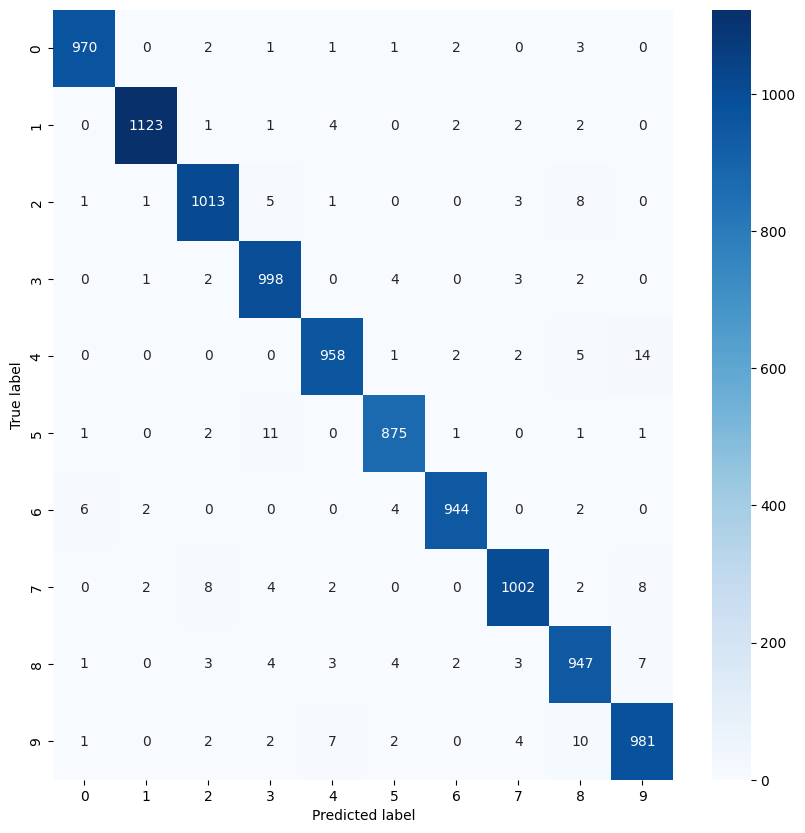

Accuracy:  0.9811


In [55]:
y_true_test = []
y_pred_test = []
best_model.to(device)
best_model.eval()
with torch.no_grad():
    for x, y in tqdm(testloader, desc='Testing', unit='batch'):
        x, y = x.to(device), y.to(device)

        output = best_model(x)
        _, predicted = torch.max(output, 1)

        y_true_test.extend(y.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())
plot_confusion_matrix(y_true_test, y_pred_test, classes=[str(i) for i in range(10)])